# Generative models

Grzegorz Statkiewicz, Mateusz Matukiewicz

## Setup

In [1]:
import torch

Select the device to use

In [2]:
device = torch.device("cuda:2") if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

print(f"Using device: {device}")

Using device: mps


## Prepare the dataset

Load the dataset. The data should be placed in the `./data` directory with the following structure:

```
data
├── 00000
│   ├── 00000_0000.jpg
│       ├── 00000_0000.jpg
|   ├── 00000_00001
│       ├── 00000_0001.jpg
```

In [3]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

images = ImageFolder("data/", transform=transform)
images_count = len(images)

print(f"Number of images: {images_count}")

Number of images: 39209


Train-test split

In [4]:
from torch.utils.data import random_split

test_size = 0.2

max_train_count = 10_000
train_count = min(int(images_count * (1 - test_size)), max_train_count if max_train_count else float('inf'))
test_count = images_count - train_count

train_ds, test_ds = random_split(images, [train_count, test_count])

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=32, shuffle=False)

print(f"Number of training images: {len(train_dl.dataset)}")
print(f"Number of test images: {len(test_dl.dataset)}")

Number of training images: 10000
Number of test images: 29209


Show samples

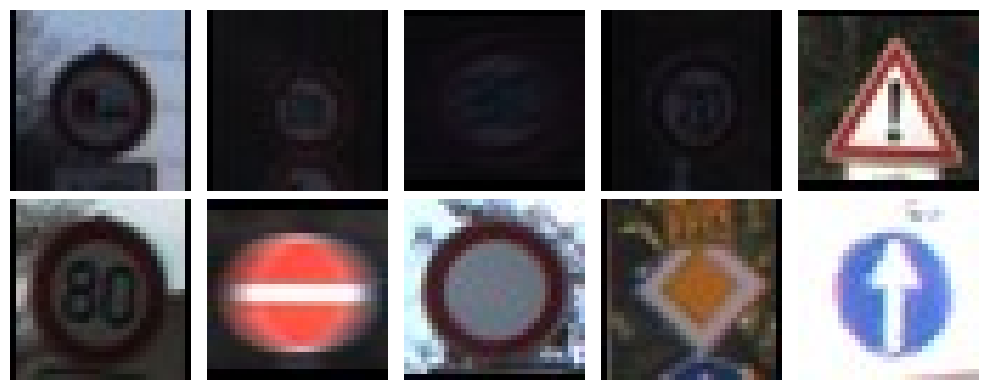

In [ ]:
from utils import denormalize_batch
from display import plot_images
import random

idxs = random.sample(range(images_count), 10)
samples = [images[i][0] for i in idxs]

# Denormalize the images
batch = torch.stack(samples)
batch = denormalize_batch(batch, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
batch = batch.clamp(0, 1)

plot_images(list(batch))

## Create the model

In [6]:
from gnn import Generator, Discriminator
import torch.optim as optim
import torch.nn as nn

# Models
latent_dim = 32
input_size = (3, 32, 32)

generator = Generator(input_size=input_size, latent_dim=latent_dim, hidden_dim=256, output_dim=3072).to(device)
discriminator = Discriminator(hidden_dim=256, input_dim=3072).to(device)

# Optimizers
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0001)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0001)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
criterion = nn.MSELoss()

Epoch: 0, discrimiantor fake error: 0.0535, discriminator real acc: 0.939


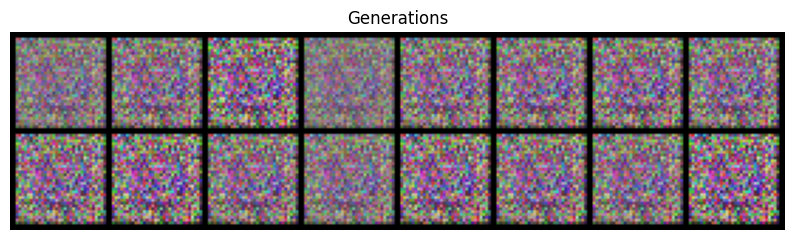

Epoch: 1, discrimiantor fake error: 0.0133, discriminator real acc: 0.973
Epoch: 2, discrimiantor fake error: 0.00688, discriminator real acc: 0.983
Epoch: 3, discrimiantor fake error: 0.00598, discriminator real acc: 0.988
Epoch: 4, discrimiantor fake error: 0.00473, discriminator real acc: 0.991
Epoch: 5, discrimiantor fake error: 0.00533, discriminator real acc: 0.992
Epoch: 6, discrimiantor fake error: 0.00888, discriminator real acc: 0.991
Epoch: 7, discrimiantor fake error: 0.0122, discriminator real acc: 0.991
Epoch: 8, discrimiantor fake error: 0.0161, discriminator real acc: 0.989
Epoch: 9, discrimiantor fake error: 0.0188, discriminator real acc: 0.984
Epoch: 10, discrimiantor fake error: 0.0199, discriminator real acc: 0.981


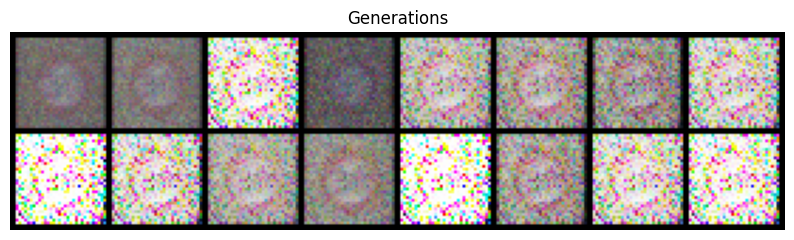

Epoch: 11, discrimiantor fake error: 0.0319, discriminator real acc: 0.973
Epoch: 12, discrimiantor fake error: 0.0388, discriminator real acc: 0.963
Epoch: 13, discrimiantor fake error: 0.0376, discriminator real acc: 0.963
Epoch: 14, discrimiantor fake error: 0.0441, discriminator real acc: 0.955
Epoch: 15, discrimiantor fake error: 0.0559, discriminator real acc: 0.94
Epoch: 16, discrimiantor fake error: 0.0929, discriminator real acc: 0.898
Epoch: 17, discrimiantor fake error: 0.138, discriminator real acc: 0.851
Epoch: 18, discrimiantor fake error: 0.143, discriminator real acc: 0.852
Epoch: 19, discrimiantor fake error: 0.168, discriminator real acc: 0.826
Epoch: 20, discrimiantor fake error: 0.177, discriminator real acc: 0.812


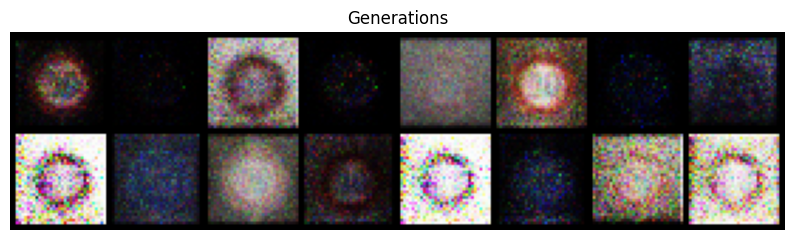

Epoch: 21, discrimiantor fake error: 0.179, discriminator real acc: 0.814
Epoch: 22, discrimiantor fake error: 0.178, discriminator real acc: 0.819
Epoch: 23, discrimiantor fake error: 0.177, discriminator real acc: 0.813
Epoch: 24, discrimiantor fake error: 0.178, discriminator real acc: 0.814
Epoch: 25, discrimiantor fake error: 0.179, discriminator real acc: 0.814
Epoch: 26, discrimiantor fake error: 0.19, discriminator real acc: 0.806
Epoch: 27, discrimiantor fake error: 0.197, discriminator real acc: 0.806
Epoch: 28, discrimiantor fake error: 0.204, discriminator real acc: 0.795
Epoch: 29, discrimiantor fake error: 0.209, discriminator real acc: 0.798
Epoch: 30, discrimiantor fake error: 0.208, discriminator real acc: 0.807


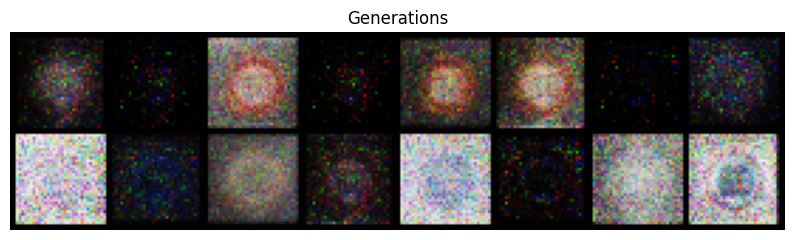

Epoch: 31, discrimiantor fake error: 0.211, discriminator real acc: 0.792
Epoch: 32, discrimiantor fake error: 0.226, discriminator real acc: 0.786
Epoch: 33, discrimiantor fake error: 0.228, discriminator real acc: 0.778
Epoch: 34, discrimiantor fake error: 0.232, discriminator real acc: 0.779
Epoch: 35, discrimiantor fake error: 0.237, discriminator real acc: 0.773
Epoch: 36, discrimiantor fake error: 0.234, discriminator real acc: 0.771
Epoch: 37, discrimiantor fake error: 0.243, discriminator real acc: 0.766
Epoch: 38, discrimiantor fake error: 0.233, discriminator real acc: 0.774
Epoch: 39, discrimiantor fake error: 0.224, discriminator real acc: 0.781
Epoch: 40, discrimiantor fake error: 0.228, discriminator real acc: 0.782


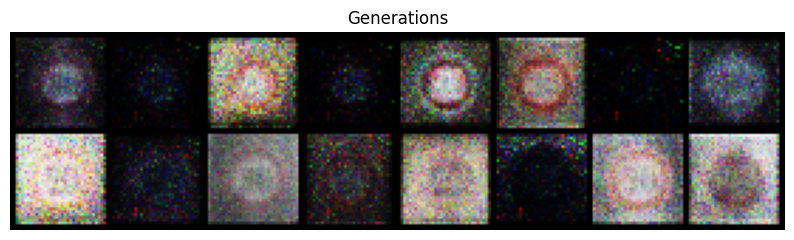

Epoch: 41, discrimiantor fake error: 0.242, discriminator real acc: 0.769
Epoch: 42, discrimiantor fake error: 0.241, discriminator real acc: 0.764
Epoch: 43, discrimiantor fake error: 0.26, discriminator real acc: 0.743
Epoch: 44, discrimiantor fake error: 0.259, discriminator real acc: 0.742
Epoch: 45, discrimiantor fake error: 0.263, discriminator real acc: 0.739
Epoch: 46, discrimiantor fake error: 0.269, discriminator real acc: 0.741


KeyboardInterrupt: 

In [7]:
from gnn import Trainer as GNNTrainer

gnn_trainer = GNNTrainer(criterion=criterion, latent_dim=latent_dim, device=device)
gnn_trainer.set_generator(generator, generator_optimizer, generator_scheduler)
gnn_trainer.set_discriminator(discriminator, discriminator_optimizer, discriminator_scheduler)

# Training
gnn_trainer.fit(train_dl, num_epochs=100)